In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import glob,cv2,time,random
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers

In [2]:
# Dense image warp from Tensorflow addons
# There is an error using tfa.image.dense_image_warp
# define same tfa.image.dense_image_warp

from tensorflow_addons.utils import types
from typing import Optional

def _get_dim(x, idx):
    if x.shape.ndims is None:
        return tf.shape(x)[idx]
    return x.shape[idx] or tf.shape(x)[idx]

def dense_image_warp(image: types.TensorLike, displacement: types.TensorLike, name: Optional[str] = None) -> tf.Tensor:
    with tf.name_scope(name or "dense_image_warp"):
        image = tf.convert_to_tensor(image)
        displacement = tf.convert_to_tensor(displacement)
        batch_size, height, width, channels = (
            _get_dim(image, 0),
            _get_dim(image, 1),
            _get_dim(image, 2),
            _get_dim(image, 3),
        )

        # The flow is defined on the image grid. Turn the flow into a list of query
        # points in the grid space.
        grid_x, grid_y = tf.meshgrid(tf.range(width), tf.range(height))
        stacked_grid = tf.cast(tf.stack([grid_y, grid_x], axis=2), displacement.dtype)
        batched_grid = tf.expand_dims(stacked_grid, axis=0)
        query_points_on_grid = batched_grid + displacement
        query_points_flattened = tf.reshape(query_points_on_grid, [batch_size, height * width, 2])
        # Compute values at the query points, then reshape the result back to the
        # image grid.
        interpolated = tfa.image.interpolate_bilinear(image, query_points_flattened)
        interpolated = tf.reshape(interpolated, [batch_size, height, width, channels])
        return interpolated

In [3]:
_dir = r'FIRE'
img_dir = _dir+'/Images/'
gt_dir = _dir+'/Ground Truth/control_points_'

In [4]:
def gt_read(file_name):
    gt_file = open(file_name)
    gt_list = []
    for keypoint in gt_file.readlines():
        gt_list.append(keypoint.split())
    return np.array(gt_list).astype(float).astype(int)

In [5]:
dataset = []
img_shape = (256,256)
for category in ['A','P','S']:
    print(category)
    img_names = glob.glob(img_dir+category+'*.*')
    gt_names = np.array(glob.glob(gt_dir+category+'*.*'))
    n = len(img_names)//2
    pairs = np.array(img_names).reshape(n,2)
    for i in range(n):
        img1 = plt.imread(pairs[i,0])
        original_shape = img1.shape[1]
        img1 = cv2.resize(img1,img_shape)
        img2 = cv2.resize(plt.imread(pairs[i,1]),img_shape)
        img_pairs = np.array([img1,img2])
        gt = gt_read(gt_names[i])*img_shape[1]/original_shape
        dataset = np.append(dataset,[category,img_pairs,gt])
dataset = dataset.reshape(dataset.shape[0]//3,3)

A


C:\Users\Admin\anaconda3\envs\tf2\lib\site-packages\numpy\core\fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


P
S


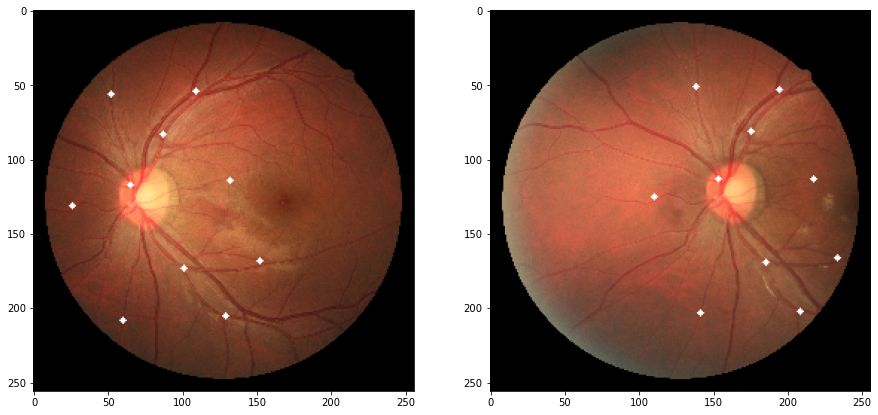

In [6]:
_id = 23
img1 = dataset[_id,1][0].copy()
img2 = dataset[_id,1][1].copy()
for kp in dataset[_id,2]:
    kp = np.int32(kp)
    cv2.circle(img1,(kp[0],kp[1]),img1.shape[0]//120,(255, 255, 255),-1)
    cv2.circle(img2,(kp[2],kp[3]),img2.shape[0]//120,(255, 255, 255),-1)
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(img1)
plt.subplot(122)
plt.imshow(img2)
plt.show()

In [7]:
N = dataset.shape[0]
train_ratio = 0.9
train_size = int(train_ratio*N)
train_ind = random.sample(range(0,N),train_size)

In [8]:
train_set = []
test_set = []
gt_train = []
gt_test = []
for ind in range(N):
    fixed_img = dataset[ind,1][0]
    moved_img = dataset[ind,1][1]
    if ind in train_ind:
        train_set.append(np.concatenate((fixed_img,moved_img),axis=-1))
        gt_train.append(dataset[ind,2])
    else:
        test_set.append(np.concatenate((fixed_img,moved_img),axis=-1))
        gt_test.append(dataset[ind,2])
train_set = tf.convert_to_tensor(train_set,float)/255
test_set = tf.convert_to_tensor(test_set,float)/255
gt_train = tf.convert_to_tensor(gt_train,float)
gt_test = tf.convert_to_tensor(gt_test,float)

In [9]:
def img_grad(imgs):
    img_x,img_y = tf.image.image_gradients(imgs)
    img_x,img_y = (img_x+tf.roll(img_x,1,1))/2, (img_y+tf.roll(img_y,1,2))/2
    return img_x,img_y

def gauss_n_down(imgs,filter_shape,down_shape):
    return tf.image.resize(tfa.image.gaussian_filter2d(imgs,filter_shape=filter_shape),down_shape)

In [10]:
def D_MSE(img1,img2):
    return tf.reduce_mean(tf.square(img1-img2))

def D_CC(img1,img2,n=9):
    gs_img1 = tfa.image.gaussian_filter2d(img1,filter_shape=(n,n))
    gs_img2 = tfa.image.gaussian_filter2d(img2,filter_shape=(n,n))
    dif_img1 = img1-gs_img1
    dif_img2 = img2-gs_img2
    cc = tf.reduce_sum(dif_img1*dif_img2,axis=[1,2,3])**2
    cc = cc/(tf.reduce_sum(dif_img1**2,axis=[1,2,3])*tf.reduce_sum(dif_img2**2,axis=[1,2,3]))
    return tf.reduce_mean(cc)

def D_NGF(img1,img2,e=1e-3):
    img1_x,img1_y = img_grad(img1)
    img2_x,img2_y = img_grad(img2)
    inner = lambda a,b: a*b+e**2
    norm_s = lambda a,b: inner(a,a)+inner(b,b)
    ngf = 1 - ((inner(img1_x,img2_x)+inner(img1_y,img2_y))**2)/(norm_s(img1_x,img1_y)*norm_s(img2_x,img2_y))
    return tf.reduce_mean(tf.reduce_sum(ngf,axis=[1,2,3]))
    
def R_difsn(u):
    u_x,u_y = img_grad(u)
    difsn = tf.cast(tf.math.reduce_sum(u_x**2+u_y**2,axis=[1,2,3]),tf.float64)
    return tf.reduce_mean(difsn)

def R_curv(u):
    u_x,u_y = tf.image.image_gradients(u) #forward different
    u_xx = u_x-tf.roll(u_x,1,1)
    u_yy = u_y-tf.roll(u_y,1,2)
    return tf.reduce_mean(tf.reduce_sum(u_xx**2+u_yy**2,axis=[1,2,3]))

def R_fold(u,t):
    u_x,u_y = tf.image.image_gradients(u)
    det_u = u_x[:,:,:,0]*u_y[:,:,:,1]-u_x[:,:,:,1]*u_y[:,:,:,0]
    mt_t = det_u[det_u>=t]
    lt_t = det_u[det_u<t]
    return (tf.reduce_sum((mt_t-1)**2/mt_t)+tf.reduce_sum((1-1/t**2)*lt_t+(2*(1-t)/t)))/tf.cast(tf.shape(u)[0],float) 

In [11]:
# inputs = layers.Input(shape=train_set[0].shape)
# Conv2D = lambda l: layers.Conv2D(l,3,activation='relu',padding='same')
# Maxpool2D = layers.MaxPool2D()
# UpSampling2D = layers.UpSampling2D()
# Concatenate = layers.Concatenate()

# x = Conv2D(16)(inputs)
# skip = []
# for _ in range(4):
#     skip.append(x)
#     x = Maxpool2D(x)
#     x = Conv2D(32)(x)
# for _ in range(4):
#     x = UpSampling2D(x)
#     x = Concatenate([x,skip.pop()])
#     x = Conv2D(32)(x)
# x = Conv2D(16)(x)
# x = Conv2D(16)(x)
# x = tf.keras.layers.Conv2D(2,3,padding='same')(x)
# model = tf.keras.Model(inputs=inputs, outputs=x,name='model')
# model.summary()
# weight_save = model.get_weights()

In [12]:
a = tf.reshape(tf.range(12,dtype=float),(4,3))
a,layers.Dropout(0.2,input_shape=(3,))(a,training=True)

(<tf.Tensor: shape=(4, 3), dtype=float32, numpy=
 array([[ 0.,  1.,  2.],
        [ 3.,  4.,  5.],
        [ 6.,  7.,  8.],
        [ 9., 10., 11.]], dtype=float32)>,
 <tf.Tensor: shape=(4, 3), dtype=float32, numpy=
 array([[ 0.  ,  1.25,  0.  ],
        [ 3.75,  5.  ,  0.  ],
        [ 0.  ,  8.75, 10.  ],
        [11.25, 12.5 , 13.75]], dtype=float32)>)

In [13]:
Conv2D = lambda l: layers.Conv2D(l,3,activation='relu',padding='same')
AveragePooling2D = layers.AveragePooling2D()
UpSampling2D = layers.UpSampling2D()
Concatenate = layers.Concatenate()

multi_layers = 3
model_list = []
if len(model_list)==0:
    for ly in range(multi_layers):
        multiplier = 2**(multi_layers-ly-1)
        rs = img_shape[0]//multiplier
        inputs = layers.Input(shape=(rs,rs,6))
        x = Conv2D(16)(inputs)
        x = Conv2D(16)(x)
        #x = layers.Dropout(0.2)(x,training=True)
        skip = []
        for i in range(3):
            skip.append(x)
            x =AveragePooling2D(x)
            l = 32*2**i
            x = Conv2D(l)(x)
            x = Conv2D(l)(x)
        for j in range(3):
            x = UpSampling2D(x)
            x = Concatenate([x,skip.pop()])
            l = 16*2**(2-j)
            x = Conv2D(l)(x)
            x = Conv2D(l)(x)
        #x = layers.Dropout(0.2)(x,training=True)
        x = layers.Conv2D(2,1,padding='same')(x)
        model = tf.keras.Model(inputs=inputs, outputs=x,name='model{}'.format(ly))
        model.summary(line_length=120)
        model_list.append(model)
    weight_save = model_list[0].get_weights()

Model: "model0"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input_1 (InputLayer)                   [(None, 64, 64, 6)]        0                                                     
________________________________________________________________________________________________________________________
conv2d (Conv2D)                        (None, 64, 64, 16)         880           input_1[0][0]                           
________________________________________________________________________________________________________________________
conv2d_1 (Conv2D)                      (None, 64, 64, 16)         2320          conv2d[0][0]                            
________________________________________________________________________________________________________________________
dropout_1 (Dropo

Model: "model2"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input_3 (InputLayer)                   [(None, 256, 256, 6)]      0                                                     
________________________________________________________________________________________________________________________
conv2d_30 (Conv2D)                     (None, 256, 256, 16)       880           input_3[0][0]                           
________________________________________________________________________________________________________________________
conv2d_31 (Conv2D)                     (None, 256, 256, 16)       2320          conv2d_30[0][0]                         
________________________________________________________________________________________________________________________
dropout_5 (Dropo

In [14]:
def loss_fn(model,imgs,r_con=[10,0.01],t=None):
    u = model(imgs)
    ref_img = imgs[:,:,:,:3]
    warped_img = dense_image_warp(imgs[:,:,:,3:],u)
    loss = D_NGF(ref_img,warped_img)+r_con[0]*R_curv(u)+r_con[1]*R_fold(u,t)
    return loss

def grad_fn(model,imgs,t=None):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(model,imgs,t=t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

def MDE_fn(u,gts):
    m = []
    for i in range(u.shape[0]):
        for j in range(gts.shape[1]):
            gt = gts[i,j]
            v = u[i][int(gt[0]),int(gt[1]),:]
            pt = tf.sqrt(tf.reduce_sum((gt[:2]+v-gt[2:])**2))
            m.append(pt)
    return tf.reduce_mean(m)

def count_fold_fn(u):
    u_x,u_y = tf.image.image_gradients(u)
    det_u = u_x[:,:,:,0]*u_y[:,:,:,1]-u_x[:,:,:,1]*u_y[:,:,:,0]
    return tf.math.count_nonzero(det_u<=0)

In [15]:
'''model.set_weights(weight_save)
epochs = 20
batch_size = train_size//10
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

loss_log = []
metric_log = []
for epoch in range(epochs):
    loss_epoch = []
    metric_epoch = []
    for i in range(0,train_size,batch_size):
        train_batch = train_set[i:i+batch_size]
        gt_batch = gt_train[i:i+batch_size]
        loss_batch, metric_batch, grads = grad_fn(model,train_batch,gt_batch)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        loss_epoch.append(loss_batch.numpy())
        metric_epoch.append(metric_batch)
    loss_test, metric_test = loss_fn(model,test_set,gt_test)
    loss_log = np.append(loss_log,[np.mean(loss_epoch),loss_test])
    metric_log = np.append(metric_log,[np.mean(metric_epoch),metric_test])
    dgt = 4 #display 'dgt' digits
    print('epoch {}, loss_train {}, loss_test {}, metric_train {}, metric_test {}'
          .format(epoch,np.round(loss_log[-2],dgt),np.round(loss_log[-1],dgt),np.round(metric_log[-2],dgt),np.round(metric_log[-1],dgt)))
loss_log = loss_log.reshape(20,2)
metric_log = metric_log.reshape(20,2)'''

"model.set_weights(weight_save)\nepochs = 20\nbatch_size = train_size//10\noptimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)\n\nloss_log = []\nmetric_log = []\nfor epoch in range(epochs):\n    loss_epoch = []\n    metric_epoch = []\n    for i in range(0,train_size,batch_size):\n        train_batch = train_set[i:i+batch_size]\n        gt_batch = gt_train[i:i+batch_size]\n        loss_batch, metric_batch, grads = grad_fn(model,train_batch,gt_batch)\n        optimizer.apply_gradients(zip(grads, model.trainable_variables))\n        loss_epoch.append(loss_batch.numpy())\n        metric_epoch.append(metric_batch)\n    loss_test, metric_test = loss_fn(model,test_set,gt_test)\n    loss_log = np.append(loss_log,[np.mean(loss_epoch),loss_test])\n    metric_log = np.append(metric_log,[np.mean(metric_epoch),metric_test])\n    dgt = 4 #display 'dgt' digits\n    print('epoch {}, loss_train {}, loss_test {}, metric_train {}, metric_test {}'\n          .format(epoch,np.round(loss_log[-2],dgt),n

In [16]:
model_list[0].set_weights(weight_save)
epochs = 25
batch_size = train_size//10
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

loss_log = []
metric_log = []
start_time = time.time()
loss_ts_log = []
test_set_full = test_set
for ly in range(multi_layers):
    for epoch in range(epochs):
        loss_epoch = []
        metric_epoch = []
        fs0 = 2**(multi_layers)-1
        multiplier0 = 2**(multi_layers-1)
        rs0 = img_shape[0]//multiplier0
        for i in range(0,train_size,batch_size):
            fs = fs0
            multiplier = multiplier0
            rs = rs0
            #initial input
            train_batch_full = train_set[i:i+batch_size]
            train_batch = gauss_n_down(train_batch_full,(fs,fs),(rs,rs))
            for j in range(ly):
                u = model_list[j](train_batch)
                u = tf.image.resize(u,img_shape)*multiplier
                warped_img = dense_image_warp(train_batch_full[:,:,:,3:],u)
                train_batch_full = tf.concat([train_batch_full[:,:,:,:3],warped_img],axis=-1)
                multiplier = multiplier//2
                fs = (fs-1)//2
                rs = 2*rs
                train_batch = gauss_n_down(train_batch_full,(fs,fs),(rs,rs))
            
            #train model
            loss_batch, grads = grad_fn(model_list[ly],train_batch,t=0.2/2**ly)
            optimizer.apply_gradients(zip(grads,model_list[ly].trainable_variables))
            
            loss_epoch.append(loss_batch.numpy())
        dgt = 4
        loss_log = np.append(loss_log,np.mean(loss_epoch))
        if ly<(multi_layers-1):
            print('layer {}, epoch {}, loss_train {}'.format(ly,epoch,np.round(loss_log[-1],dgt)))
        else:
            test_set_small = gauss_n_down(test_set_full,(fs0,fs0),(rs0,rs0))
            for j in range(ly):
                u = model_list[j](test_set_small)
                u = tf.image.resize(u,img_shape)*multiplier0
                warped_img = dense_image_warp(test_set_full[:,:,:,3:],u)
                test_set_full = tf.concat([test_set_full[:,:,:,:3],warped_img],axis=-1)
                multiplier0 = multiplier0//2
                fs0 = (fs0-1)//2
                rs0 = 2*rs0
                test_set_small = gauss_n_down(test_set_full,(fs0,fs0),(rs0,rs0))
            loss_test = loss_fn(model_list[ly],test_set_small,t=0.2/2**ly).numpy()
            loss_ts_log.append(loss_test)
            print('layer {}, epoch {}, loss_train {}, loss_train {}'
                  .format(ly,epoch,np.round(loss_log[-1],dgt),np.round(loss_test,dgt)))
            
print('time used = {} second'.format(time.time()-start_time))

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
layer 0, epoch 0, loss_train 3942.377
layer 0, epoch 1, loss_train 3709.5669
layer 0, epoch 2, loss_train 3708.3003
layer 0, epoch 3, loss_train 3708.2754
layer 0, epoch 4, loss_train 3708.1577
layer 0, epoch 5, loss_train 3708.1841
layer 0, epoch 6, loss_train 3708.1523
layer 0, epoch 7, loss_train 3708.1394
layer 0, epoch 8, loss_train 3708.0522
layer 0, epoch 9, loss_train 3708.0481
layer 0, epoch 10, loss_train 3708.2769
layer 0, epoch 11, loss_train 3708.0229
layer 0, epoch 12, loss_train 3708.0767
layer 0, epoch 13, loss_train 3708.03
layer 0, epoch 14, loss_train 3707.9871
layer 0, epoch 15, loss_train 3707.8745
layer 0, epoch 16, loss_train 3707.8354
layer 0, epoch 17, loss_train 3707.6855
layer 0, epoch 18, loss_train 3707.6746
layer 0, epoch 19, loss_train 3707.3657
layer 0, epoch 20, loss_train 3707.1316
layer 0, epoch 21, loss_train 3706.

In [20]:
loss_log

array([[  3942.37695312,   3709.56689453,   3708.30029297,
          3708.27539062,   3708.15771484,   3708.18408203,
          3708.15234375,   3708.1394043 ,   3708.05224609,
          3708.0480957 ,   3708.27685547,   3708.02294922,
          3708.07666016,   3708.0300293 ,   3707.98706055,
          3707.87451172,   3707.83544922,   3707.68554688,
          3707.67456055,   3707.36572266,   3707.1315918 ,
          3706.79833984,   3706.59179688,   3706.35351562,
          3706.31494141],
       [ 19218.12109375,  19089.02929688,  19088.36914062,
         19090.81640625,  19086.54492188,  19086.953125  ,
         19086.03125   ,  19086.09960938,  19085.51171875,
         19085.42773438,  19085.46875   ,  19084.9609375 ,
         19085.125     ,  19084.94335938,  19084.75390625,
         19084.84375   ,  19084.73828125,  19084.875     ,
         19084.63867188,  19084.70117188,  19084.71679688,
         19084.75976562,  19084.62890625,  19084.42578125,
         19084.69335938],
    

In [17]:
loss_log = loss_log.reshape(multi_layers,epochs)

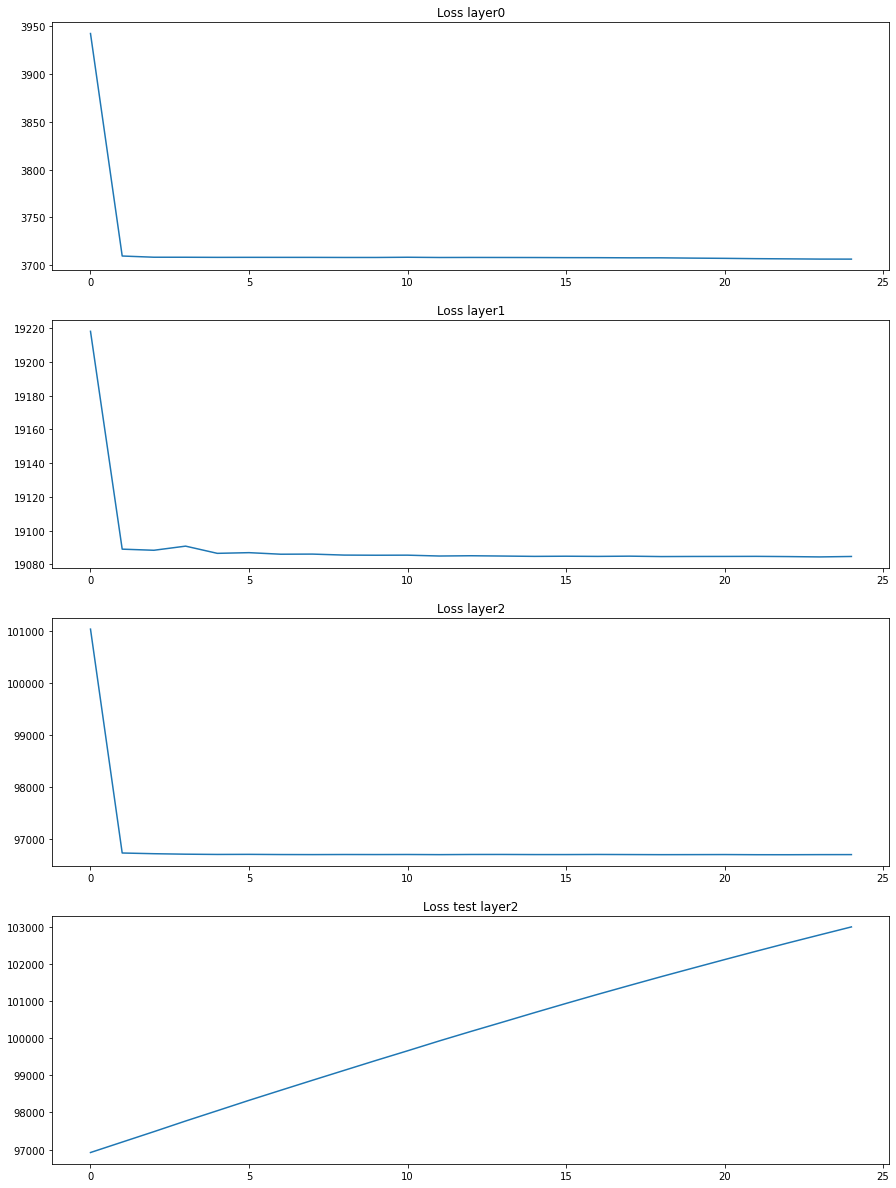

In [21]:
number_plot = 3
plt.figure(figsize=(15,number_plot*7))
plt.subplot(411)
plt.title('Loss layer0')
plt.plot(loss_log[0,:],label='train')
plt.subplot(412)
plt.title('Loss layer1')
plt.plot(loss_log[1,:],label='train')
plt.subplot(413)
plt.title('Loss layer2')
plt.plot(loss_log[2,:],label='train')
plt.subplot(414)
plt.title('Loss test layer2')
plt.plot(loss_ts_log,label='test')
plt.show()

In [23]:
u

<tf.Tensor: shape=(256, 256, 6), dtype=float32, numpy=
array([[[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0

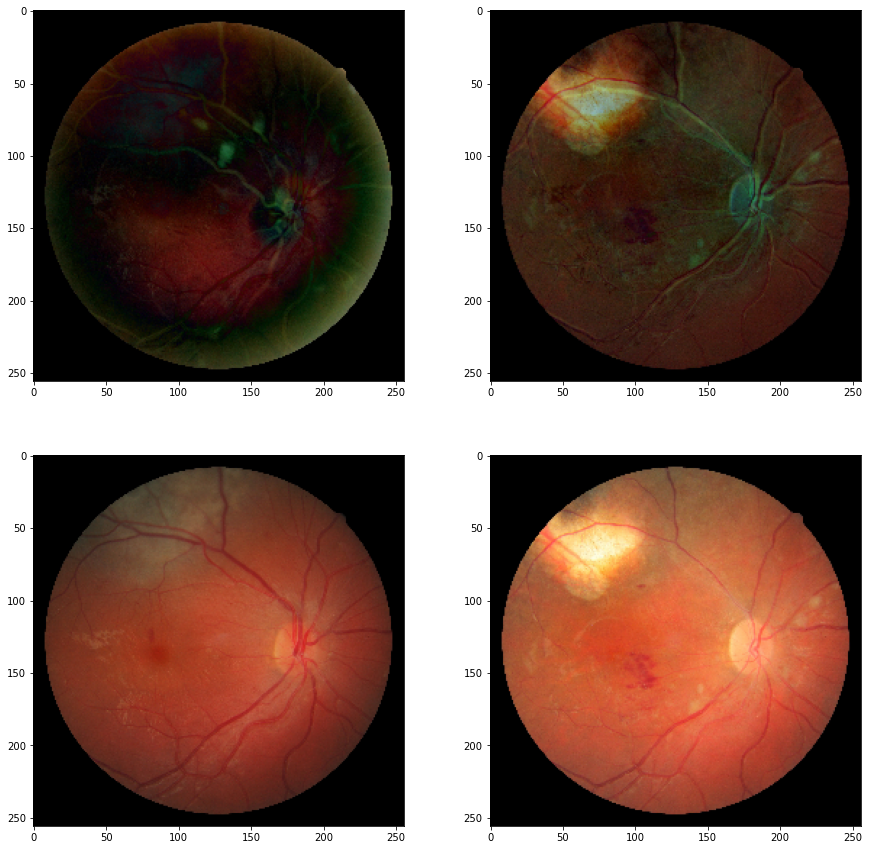

In [31]:
_id = 0
test_set_full = tf.expand_dims(train_set[7],0)
fs0 = 2**(multi_layers)-1
multiplier0 = 2**(multi_layers-1)
rs0 = img_shape[0]//multiplier0
for j in range(ly+1):
    test_set_small = gauss_n_down(test_set_full,(fs0,fs0),(rs0,rs0))
    u = model_list[j](test_set_small)
    u = tf.image.resize(u,img_shape)*multiplier0
    warped_img = dense_image_warp(test_set_full[:,:,:,3:],u)
    test_set_full = tf.concat([test_set_full[:,:,:,:3],warped_img],axis=-1)
    multiplier0 = multiplier0//2
    fs0 = (fs0-1)//2
    rs0 = 2*rs0
    
diff_original = abs(test_set_full[0][:,:,:3]-train_set[3][:,:,3:])
#diff_original/=np.max(diff_original)
diff_registed = abs(test_set_full[0][:,:,:3]-test_set_full[0][:,:,3:])
#diff_registed/=np.max(diff_registed)
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(diff_original)
plt.subplot(222)
plt.imshow(diff_registed)
plt.subplot(223)
plt.imshow(test_set_full[0][:,:,:3])
plt.subplot(224)
plt.imshow(test_set_full[0][:,:,3:])
plt.show()